In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd
import pytz
import xarray

from config import poa_data_path, MAURITIUS_CONTOUR_FILE, data_path
from utils import plot_map

tz = pytz.timezone("Etc/GMT+4")
date_range = [
    datetime(2019, 1, 1),
    datetime(2020, 1, 1) - timedelta(minutes=30)
]

azimuth_range = range(-180, 190, 10)
tilt_range = range(0, 100, 10)


def get_poa_for_azimuth_tilt(azimuth, tilt):
    poa = xarray.open_dataset(poa_data_path / f"{tilt}_{azimuth}.nc")
    poa = poa.to_dataframe().reset_index().set_index("time")
    poa = poa[date_range[0]:date_range[1]].groupby(['lat', 'lon']).mean().reset_index()
    return poa


ModuleNotFoundError: No module named 'utils'

In [2]:
% matplotlib widget

# Visualizing POA irradiance over the selected date_range with flat panel

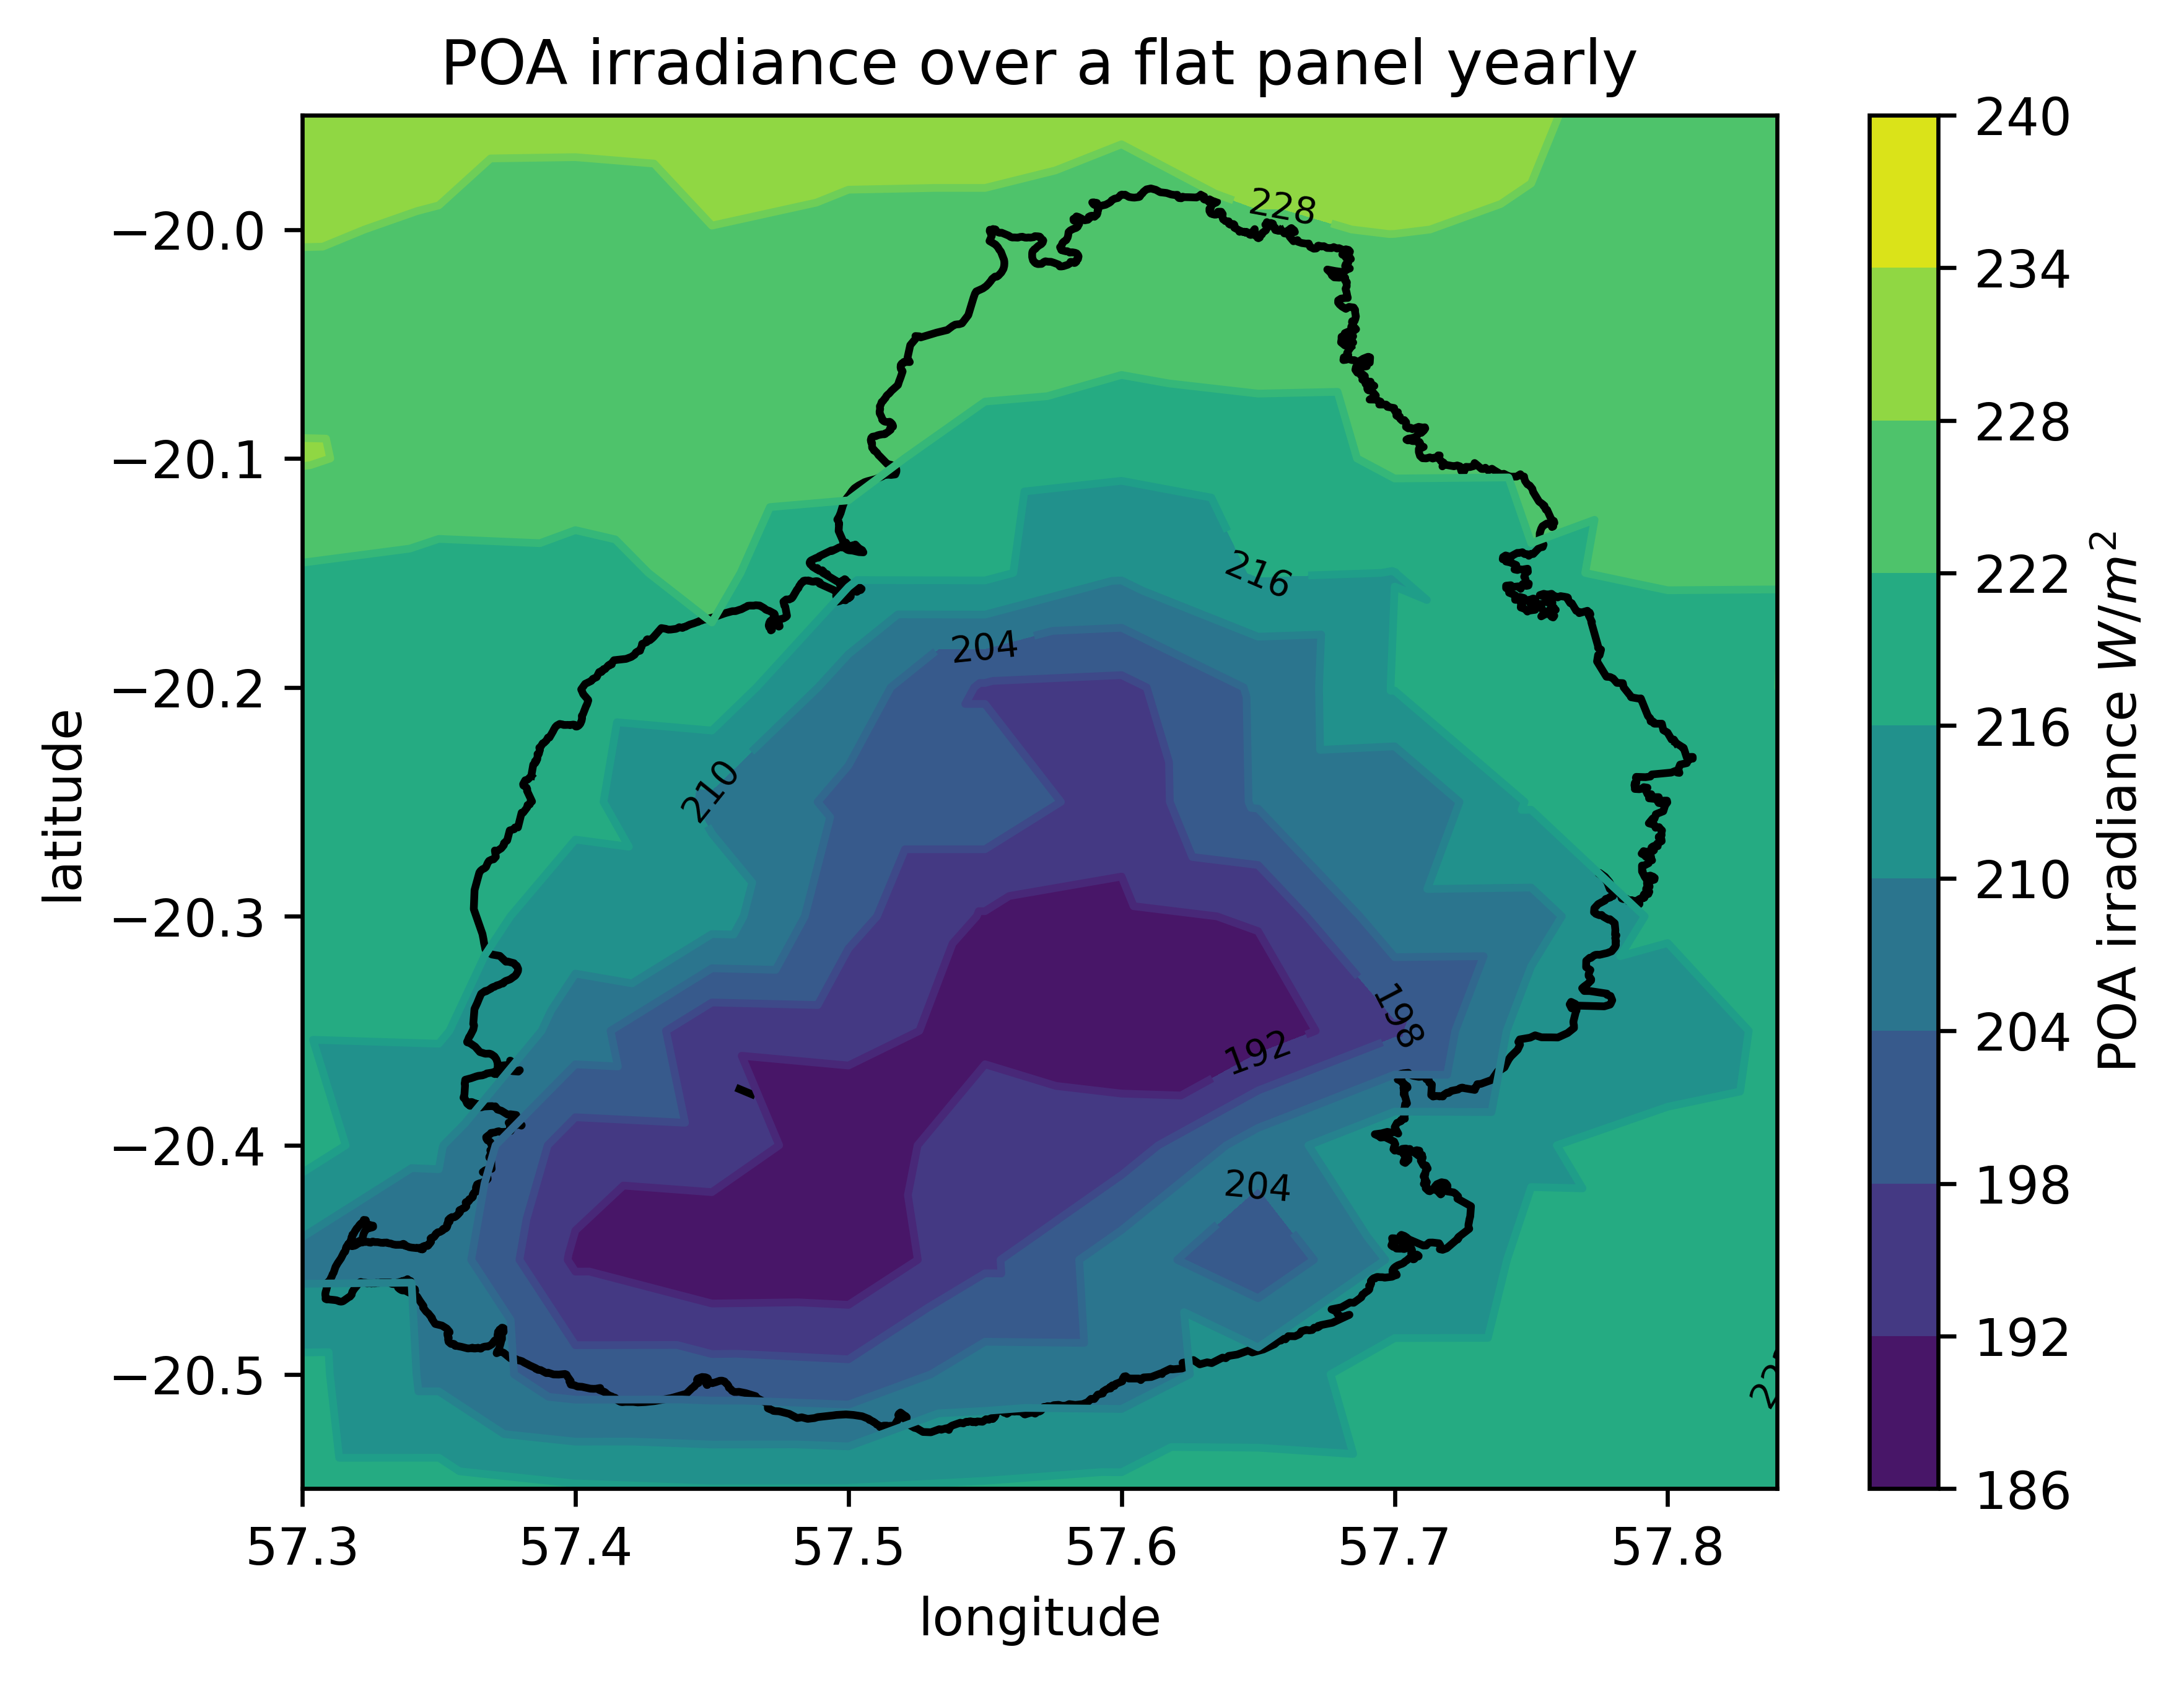

In [10]:
poa_0_0 = get_poa_for_azimuth_tilt(0, 0)
fig = plt.figure()
fig.set_dpi(600)
ax = fig.add_subplot()
ax.set_title(f"POA irradiance over a flat panel yearly")
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plot_map(ax, MAURITIUS_CONTOUR_FILE)

contourf = ax.tricontourf(poa_0_0['lon'], poa_0_0['lat'], poa_0_0['POA_GLOBAL_IRRADIANCE'], )
contour = ax.tricontour(poa_0_0['lon'], poa_0_0['lat'], poa_0_0['POA_GLOBAL_IRRADIANCE'], )

ax.clabel(contour, inline=1, fontsize=7, colors='black')
plt.xlim([57.3, 57.84])
plt.ylim([-20.55, -19.95])
fig.colorbar(contourf, label='POA irradiance $W/m^2$')
plt.show()

In [11]:
def get_transposition_factor(azimuth, tilt):
    poa = get_poa_for_azimuth_tilt(azimuth, tilt)
    transposition_factor = poa["POA_GLOBAL_IRRADIANCE"] / poa_0_0["POA_GLOBAL_IRRADIANCE"]
    poa["transposition_factor"] = transposition_factor
    return poa


def select_lat_lon(df, lat, lon):
    return df[(df["lat"] == lat) & (df["lon"] == lon)]

# Finding best tilt azimuth for a year

In [24]:
best_tilt_azimuth = pd.DataFrame(
    columns=["lat", "lon", "transposition_factor", "tilt", "azimuth", "POA_GLOBAL_IRRADIANCE"])
for lat in poa_0_0["lat"].unique():
    for lon in poa_0_0["lon"].unique():
        # insert 0 as default value
        best_tilt_azimuth = pd.concat([best_tilt_azimuth, pd.DataFrame({
            'lat': [lat],
            'lon': [lon],
            'transposition_factor': [0],
            'tilt': [0],
            'azimuth': [0],
            'POA_GLOBAL_IRRADIANCE': [0]
        })])

for azimuth in azimuth_range:
    for tilt in tilt_range:
        print(f"Processing {azimuth} {tilt}")
        transposition_factor = get_transposition_factor(azimuth, tilt)
        for lat in transposition_factor["lat"].unique():
            for lon in transposition_factor["lon"].unique():
                if select_lat_lon(transposition_factor, lat, lon)['transposition_factor'].values[0] > \
                        select_lat_lon(best_tilt_azimuth, lat, lon)['transposition_factor'].values[0]:
                    best_tilt_azimuth.loc[
                        (best_tilt_azimuth["lat"] == lat) & (best_tilt_azimuth["lon"] == lon), "transposition_factor"] = \
                        select_lat_lon(transposition_factor, lat, lon)['transposition_factor'].values[0]
                    best_tilt_azimuth.loc[
                        (best_tilt_azimuth["lat"] == lat) & (best_tilt_azimuth["lon"] == lon), "tilt"] = tilt
                    best_tilt_azimuth.loc[
                        (best_tilt_azimuth["lat"] == lat) & (best_tilt_azimuth["lon"] == lon), "azimuth"] = azimuth
                    best_tilt_azimuth.loc[
                        (best_tilt_azimuth["lat"] == lat) & (
                                best_tilt_azimuth["lon"] == lon), "POA_GLOBAL_IRRADIANCE"] = \
                        select_lat_lon(transposition_factor, lat, lon)['POA_GLOBAL_IRRADIANCE'].values[0]





Processing -180 0
Processing -180 10
Processing -180 20
Processing -180 30
Processing -180 40
Processing -180 50
Processing -180 60
Processing -180 70
Processing -180 80
Processing -180 90
Processing -170 0
Processing -170 10
Processing -170 20
Processing -170 30
Processing -170 40
Processing -170 50
Processing -170 60
Processing -170 70
Processing -170 80
Processing -170 90
Processing -160 0
Processing -160 10
Processing -160 20
Processing -160 30
Processing -160 40
Processing -160 50
Processing -160 60
Processing -160 70
Processing -160 80
Processing -160 90
Processing -150 0
Processing -150 10
Processing -150 20
Processing -150 30
Processing -150 40
Processing -150 50
Processing -150 60
Processing -150 70
Processing -150 80
Processing -150 90
Processing -140 0
Processing -140 10
Processing -140 20
Processing -140 30
Processing -140 40
Processing -140 50
Processing -140 60
Processing -140 70
Processing -140 80
Processing -140 90
Processing -130 0
Processing -130 10
Processing -130 20

In [25]:
best_tilt_azimuth.to_csv(str(data_path / "best_tilt_azimuth_yearly.csv"))

# Plotting the best tilt and azimuth for every position

In [32]:
best_tilt_azimuth = pd.read_csv(str(data_path / "best_tilt_azimuth_yearly.csv")).groupby(['lat', 'lon']).mean().reset_index()

# Plotting the best POA irradiance

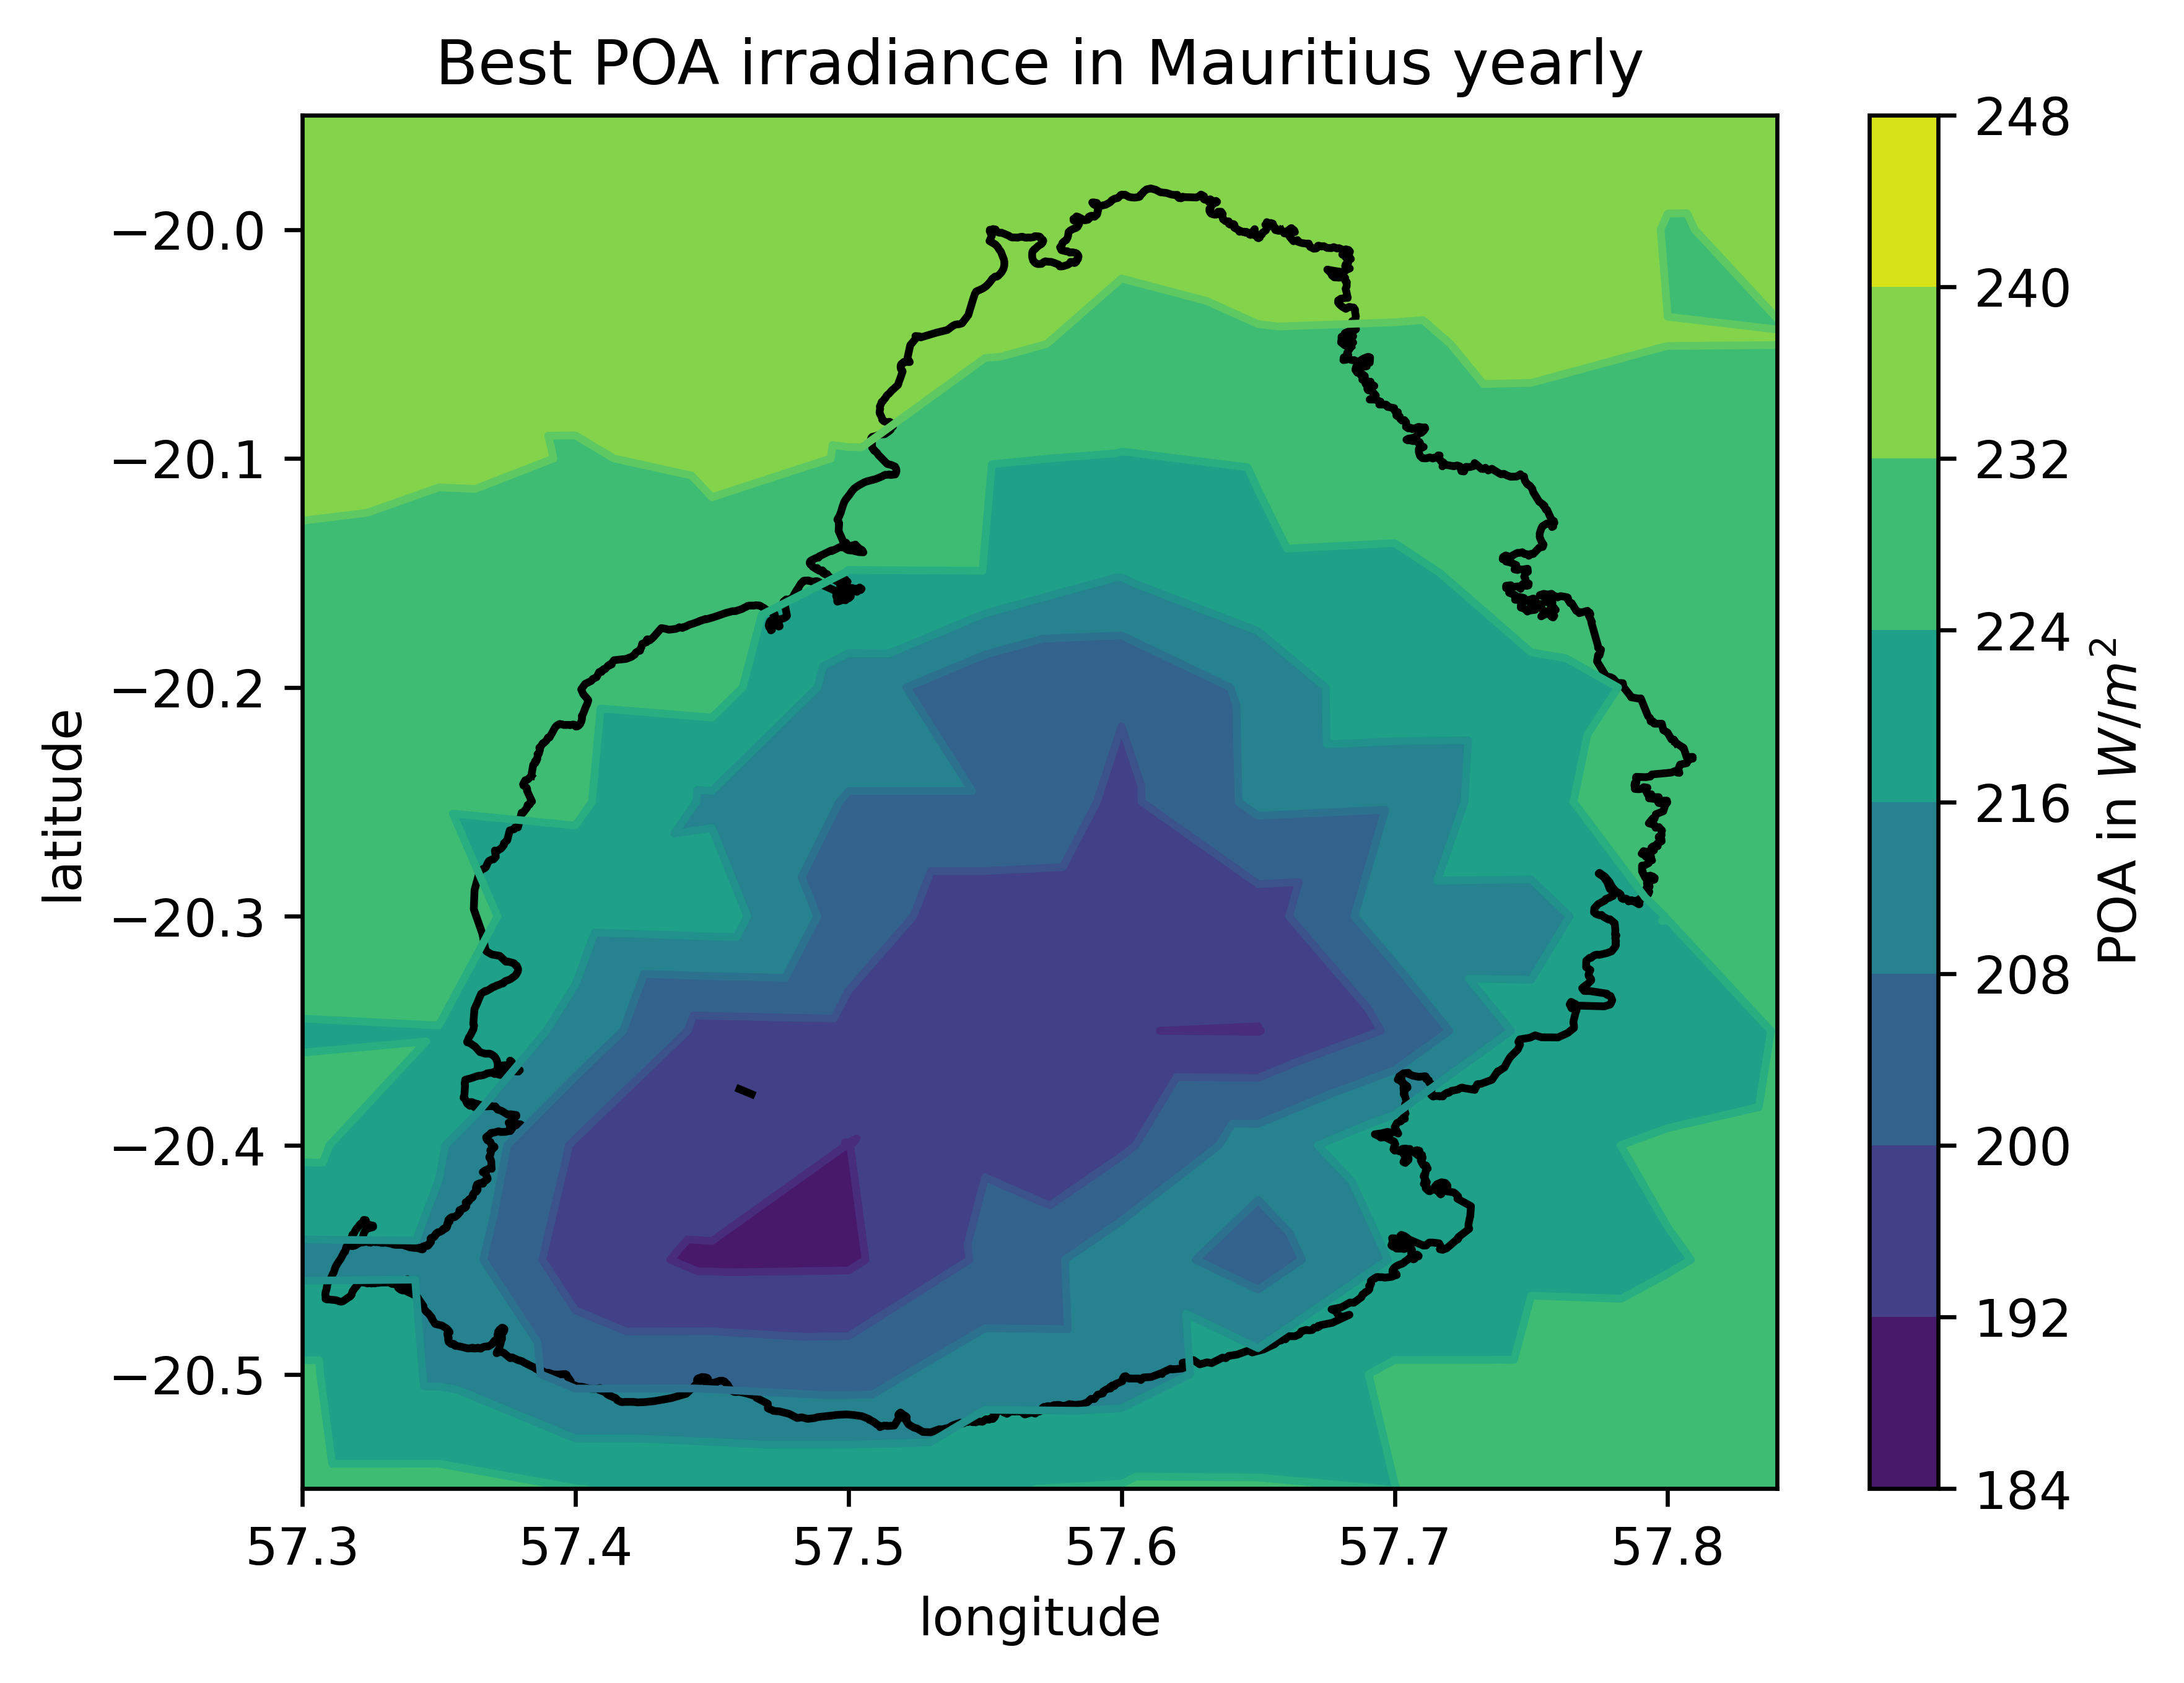

In [33]:
fig = plt.figure()
fig.set_dpi(600)
ax = fig.add_subplot()
ax.set_title(f"Best POA irradiance in Mauritius yearly", )
ax.set_ylabel('latitude', )
ax.set_xlabel('longitude', )
ax.set_zorder(3)

plot_map(ax, MAURITIUS_CONTOUR_FILE)

contourf = ax.tricontourf(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                          best_tilt_azimuth['POA_GLOBAL_IRRADIANCE'], )
contour = ax.tricontour(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                        best_tilt_azimuth['POA_GLOBAL_IRRADIANCE'], )
cb = fig.colorbar(contourf)
cb.set_label(label='POA in $W/m^2$')
plt.xlim([57.3, 57.84])
plt.ylim([-20.55, -19.95])
plt.show()

# Plotting transposition factor

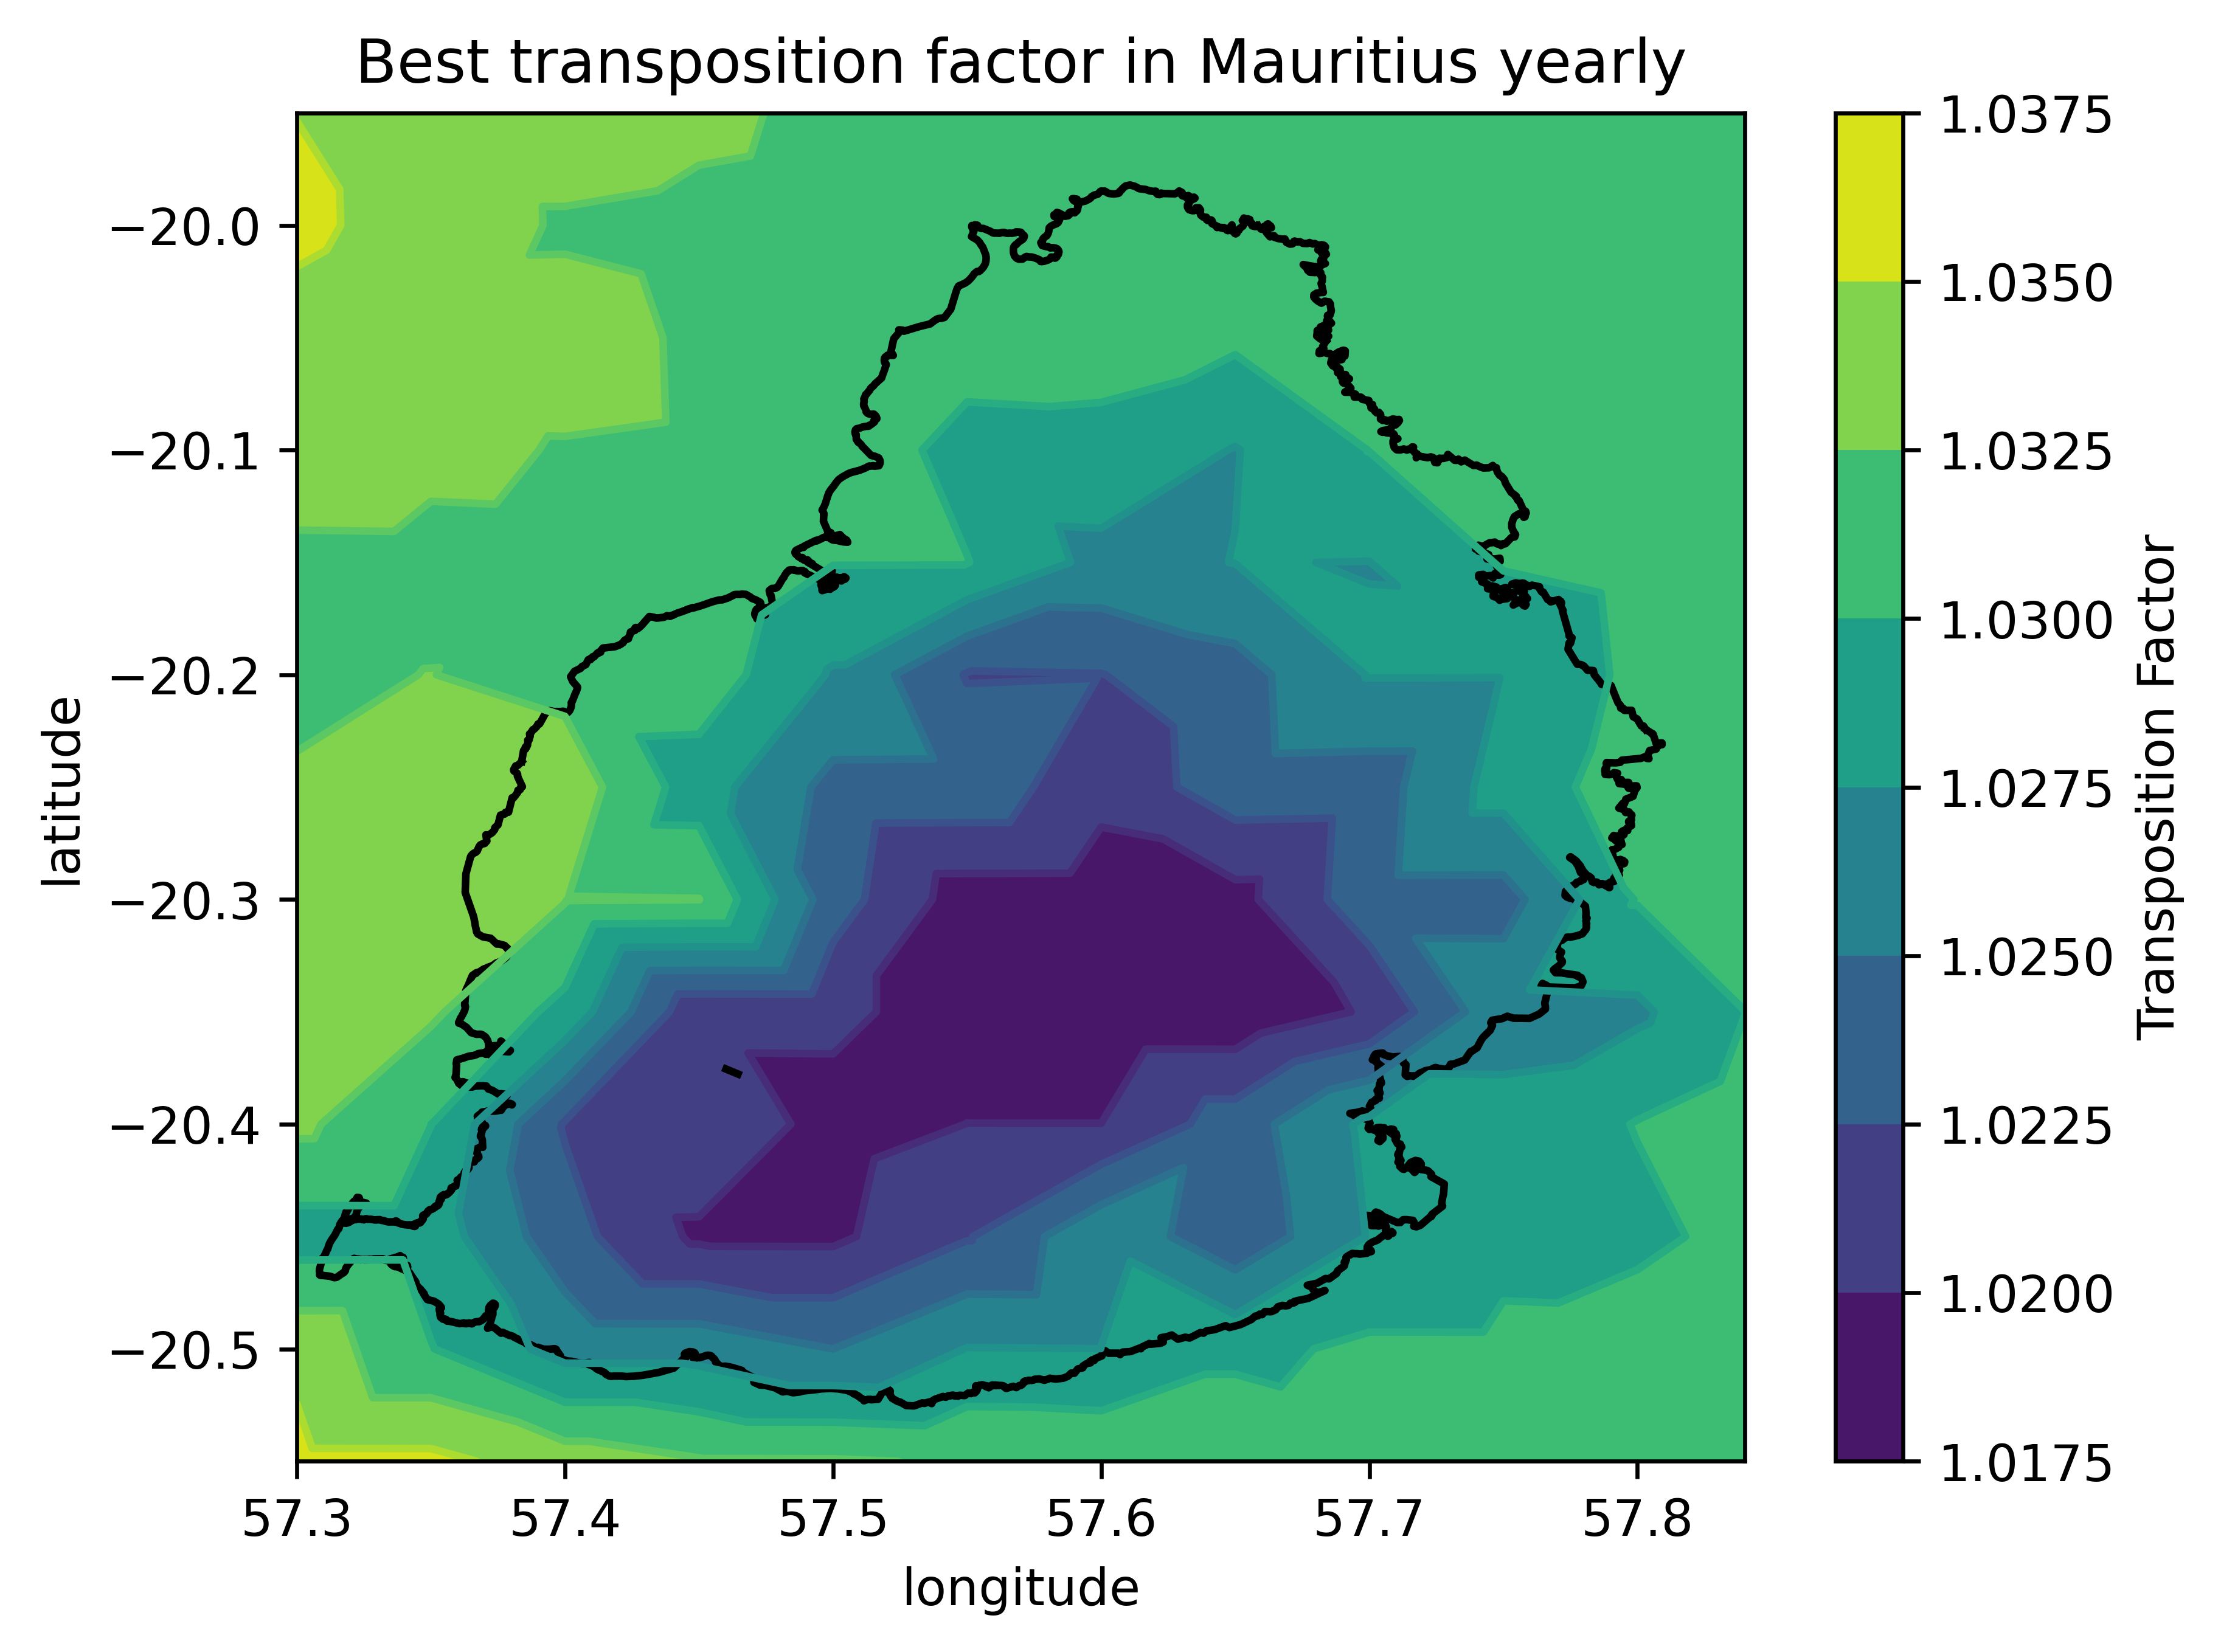

In [28]:

fig = plt.figure()
fig.set_dpi(600)
ax = fig.add_subplot()
ax.set_title(f"Best transposition factor in Mauritius yearly", )
ax.set_ylabel('latitude', )
ax.set_xlabel('longitude', )
ax.set_zorder(3)

plot_map(ax, MAURITIUS_CONTOUR_FILE)

contourf = ax.tricontourf(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                          best_tilt_azimuth['transposition_factor'], )
contour = ax.tricontour(best_tilt_azimuth['lon'], best_tilt_azimuth['lat'],
                        best_tilt_azimuth['transposition_factor'], )
cb = fig.colorbar(contourf)
cb.set_label(label='Transposition Factor')
plt.xlim([57.3, 57.84])
plt.ylim([-20.55, -19.95])
plt.show()